# Linear Regression

#### Loss function :$$\mathcal{L}(w,b)=\frac{1}{n}\sum_{i=1}^{n}l^{i}(w, b)=\frac{1}{n}\sum_{i=1}^{n}\frac{1}{2}(w^T x^{(i)}+b-y^{(i)})^2$$

#### Analytic solution:
$$
Y = XA+\epsilon
$$
$$
\|\epsilon\|^2 = (Y-XA)^T(Y-XA)
$$
$$
=(Y^T-A^{T}X^T)(Y-XA)=Y^{T}Y-A^{T}X^{T}Y-Y^{T}XA+A^{T}X^{T}XA
$$
$$
\frac{\partial \|\epsilon\|^2}{\partial A} = 0 - X^{T}Y-(Y^{T}X)^{T}+(X^{T}X+(X^{T}X)^T)A=0
$$
$$
X^{T}XA = X^{T}Y
$$
$$
A = (X^{T}X)^{-1}X^{T}Y
$$

### Vectorization for speed

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [7]:
class Timer:
    def __init__(self):
        self.times = []
        self.start()
    
    def start(self):
        self.tik = time.time()
        
    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        return sum(self.times) / len(self.times)
    
    def sum(self):
        return sum(self.times)
    
    def cumsum(self):
        return np.array(self.times).cumsum().tolist()
    

In [8]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.08178 sec'

In [9]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00100 sec'

### Normal Distribution and Squared Loss

$$
p(x)=\frac{1}{\sqrt{2\pi}\sigma}exp(-\frac{1}{2\sigma^2}(x-\mu)^2)
$$

In [10]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5/sigma**2 * (x - mu)**2)

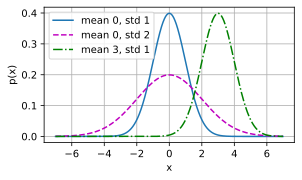

In [11]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)
# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
ylabel='p(x)', figsize=(4.5, 2.5),
legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

#### noisy obervations
$$
y = w^{T}x+b+\epsilon \quad where \quad \epsilon-\mathcal{N}(0, \sigma^2)
$$

#### likelihood function

$$
P(y|x) = \frac{1}{\sqrt{2\pi \sigma^2}}exp(-\frac{1}{2\sigma^2}(y-w^{T}x-b)^2)
$$

$$
P(Y|X)=\prod_{i=1}^{n}p(y^{(i)}|x^{(i)})
$$

#### It follows that minimizing the mean squared error is equivalent to maximum likelihood estimation of a linear model under the assumption of additive Gaussian noise

$$
-logP(Y|X)=\sum_{i=1}^{n}\frac{1}{2}log(2\pi\sigma^2)+\frac{1}{2\sigma^2}(y^{(i)}-w^{T}x^{(i)}-b)^2
$$

## Linear Regression Implementation from Scratch

#### Generating the Dataset

In [12]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

-1 代表通配符，reshape((-1, 1))表示转换成一列

In [26]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [27]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [28]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([0.8589, 0.3649]) 
label: tensor([4.6872])


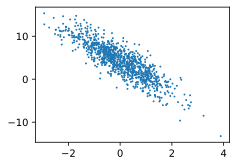

In [29]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(),
labels.detach().numpy(), 1);

#### Reading the Dataset

In [40]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [41]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.2780, -1.2914],
        [-0.0326,  1.4112],
        [ 0.5602, -0.6835],
        [-1.3507,  0.9685],
        [-1.5663, -1.0150],
        [ 0.4472,  0.5850],
        [-0.4765,  0.3991],
        [ 0.4958,  0.0052],
        [ 0.6736, -2.5677],
        [-0.6104,  0.2191]]) 
 tensor([[13.1499],
        [-0.6717],
        [ 7.6416],
        [-1.7884],
        [ 4.5367],
        [ 3.1050],
        [ 1.8819],
        [ 5.1928],
        [14.2813],
        [ 2.2397]])


#### Initializing Model Parameters

In [42]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

#### Defining the Model

In [43]:
def linreg(X, w, b): #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

#### Defining the Loss Function

In [44]:
def squared_loss(y_hat, y): #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

#### Defining the Optimization Algorithm (stochastic gradient descent)
size of the update step is
determined by the learning rate lr

loss is calculated as a sum over the minibatch of
examples, we normalize step size by the batch size (batch_size)

torch.no_grad() 是一个上下文管理器，被该语句 wrap 起来的部分将不会track 梯度

.grad.zero_()“清除”x的梯度值，也就是重新赋值为0

In [45]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()